Importing And Installing Dependencies

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os 
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
physicsal_devices=tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physicsal_devices[0],True)
except:
  pass

Build Data Loading Functions

In [3]:
import gdown

In [4]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [4]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:05<00:00, 75.2MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str)->List[float]:
  cap=cv2.VideoCapture(path)
  frames=[]
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret,frame=cap.read()
    frame=tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()

  mean=tf.math.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))

  return tf.cast((frames-mean),tf.float32)/std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num(['r','i','s','h','i'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([18,  9, 19,  8,  9])>

In [9]:
num_to_char([18,  9, 19,  8,  9])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'r', b'i', b's', b'h', b'i'], dtype=object)>

In [10]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [11]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [ ]:
test_path='./data/s1/bbal6n.mpg'

In [ ]:
frames,alignments=load_data(tf.convert_to_tensor(test_path))

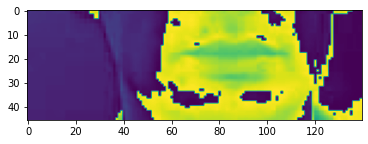

In [ ]:
plt.imshow(frames[0])

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str)->List[str]:
  results=tf.py_function(load_data,[path],(tf.float32,tf.int64))
  return results

Create Data Pipeline

In [ ]:
data=tf.data.Dataset.list_files('./data/s1/*.mpg')
data=data.shuffle(500,reshuffle_each_iteration=False)
data=data.map(mappable_function)
data=data.padded_batch(2,padded_shapes=([75,None,None,None],[40]))
data=data.prefetch(tf.data.AUTOTUNE)
#
train=data.take(450)
test=data.skip(450)

In [ ]:
frames,alignments=data.as_numpy_iterator().next()

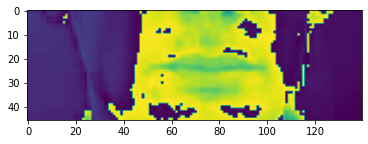

In [ ]:
plt.imshow(frames[0][0])

In [ ]:
len(frames)

2

In [ ]:
  test=data.as_numpy_iterator()

In [ ]:
val=test.next();val[0]

array([[[[[ 1.4154263 ],
          [ 1.4547436 ],
          [ 1.1008871 ],
          ...,
          [ 0.31453916],
          [ 0.23590438],
          [ 0.23590438]],

         [[ 1.4547436 ],
          [ 1.4547436 ],
          [ 1.1402044 ],
          ...,
          [ 0.31453916],
          [ 0.23590438],
          [ 0.23590438]],

         [[ 1.494061  ],
          [ 1.494061  ],
          [ 1.4154263 ],
          ...,
          [ 0.31453916],
          [ 0.23590438],
          [ 0.23590438]],

         ...,

         [[ 1.0615697 ],
          [ 1.0615697 ],
          [ 1.0615697 ],
          ...,
          [ 0.0393174 ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0222523 ],
          [ 1.0222523 ],
          [ 1.0222523 ],
          ...,
          [ 0.0393174 ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0222523 ],
          [ 1.0222523 ],
          [ 1.0222523 ],
          ...,
          [ 0.0393174 ],
          [ 0.        ],
          

In [ ]:
imageio.mimsave('./animation.gif',val[0][1],fps=10)

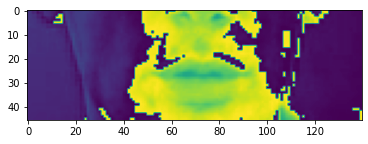

In [ ]:
# 0:videos , 0 1st video out of the batch , 0:return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue at p zero please'>

Design And Develop Neural Networks

In [16]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [17]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
yhat=model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'!!aaaa111111111111111111111111111111111111111111111111111111111111111111111'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

Setup Training Options And Train

In [ ]:
def scheduler(epoch,lr):
  if epoch <30:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

In [21]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [ ]:
schedule_callback = LearningRateScheduler(scheduler)


In [ ]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 2s 2s/step
Original: bin red by a zero please
Prediction: l e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by e two now
Prediction: l e e e n o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 510s 1s/step - loss: 85.6994 - val_loss: 70.5875 - lr: 1.0000e-04
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: 71.2996

1/1 [==============================] - 0s 64ms/step
Original: place red by d zero now
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue by k six please
Prediction: la e e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 259s 575ms/step - loss: 71.2996 - lr: 1.0000e-04
Epoch 3/100
1/1 [==============================] - 0s 54ms/step
Original: set white by i four now
Prediction: la e e i e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue in v zero please
Prediction: la e e i e eon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 260s 578ms/step - loss: 67.2464 - lr: 1.0000e-04
Epoch 4/100
1/1 [==============================] -

In [ ]:
model.save('LipNet(1).h5')

Making Predictions

In [46]:
sample=load_data(tf.convert_to_tensor('./data/s1/lbid4p.mpg'))

In [47]:
model.load_weights('LipNet(1).h5')

In [48]:
yhat =model.predict(tf.expand_dims(sample[0],axis=0))

1/1 [==============================] - 0s 42ms/step


In [49]:
print('~'*100,'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in d four please'>]

In [50]:
decoded=tf.keras.backend.ctc_decode(yhat,input_length=[75],greedy=True)[0][0].numpy()

In [51]:
print('~'*100,'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in de]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue in d four please'>]